# seagliderOG1 demo

The purpose of this notebook is to demonstrate the functionality of `seagliderOG1` to convert from Seaglider basestation files to OG1 format.

- OG1 format is a newly agreed format (since June 2024) for glider data sets from various platforms (e.g., Seaglider, Slocum, Seaexplorer).  It lives on github here: (https://github.com/OceanGlidersCommunity/OG-format-user-manual).
- OG1 manual: https://oceangliderscommunity.github.io/OG-format-user-manual/OG_Format.html

The test case is to convert sg015 data from the Labrador Sea in September 2004.

The demo is organised to show

- Conversion of a single dive cycle (single `p*.nc` file)

- Conversion for a folder of local dive-cycle files (full mission of `p*.nc` files)

- Download from remote server + conversion (directory with full mission of `p*.nc` files)

Options are provided to only load e.g. 10 files, but note that OG1 format expects a full mission.


In [1]:
import pathlib
import sys

script_dir = pathlib.Path().parent.absolute()
parent_dir = script_dir.parents[0]
sys.path.append(str(parent_dir))
sys.path.append(str(parent_dir) + '/seagliderOG1')
print(parent_dir)
print(sys.path)
### silence future warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import xarray as xr
import os
import pooch
from seagliderOG1 import readers, writers, plotters, tools
from seagliderOG1 import convertOG1, vocabularies


/Users/tillmoritz/Desktop/Work/Git/seagliderOG1
['/Users/tillmoritz/Desktop/Work/Git/seagliderOG1/notebooks', '/Users/tillmoritz/miniconda3/envs/seagliderOG1/lib/python313.zip', '/Users/tillmoritz/miniconda3/envs/seagliderOG1/lib/python3.13', '/Users/tillmoritz/miniconda3/envs/seagliderOG1/lib/python3.13/lib-dynload', '', '/Users/tillmoritz/miniconda3/envs/seagliderOG1/lib/python3.13/site-packages', '/Users/tillmoritz/Desktop/Work/Git/seagliderOG1', '/Users/tillmoritz/Desktop/Work/Git/seagliderOG1/seagliderOG1']


In [2]:
# Specify the path for writing datafiles
data_path = os.path.join(parent_dir, 'data')

## Reading basestation files

This has three ways to load a glider dataset.

Load an example dataset using `seagliderOG1.fetchers.load_sample_dataset`

Alternatively, use your own with e.g. `ds = xr.open_dataset('/path/to/yourfile.nc')`

### Load single sample dataset

In [3]:
ds = readers.load_sample_dataset()
ds

<xarray.Dataset> Size: 290kB
Dimensions:                                   (sg_data_point: 586,
                                               gc_event: 36, gc_state: 10,
                                               gps_info: 3, trajectory: 1)
Coordinates:
    ctd_time                                  (sg_data_point) datetime64[ns] 5kB ...
    longitude                                 (sg_data_point) float64 5kB ...
    latitude                                  (sg_data_point) float64 5kB ...
    ctd_depth                                 (sg_data_point) float64 5kB ...
  * trajectory                                (trajectory) int32 4B 15
Dimensions without coordinates: sg_data_point, gc_event, gc_state, gps_info
Data variables: (12/397)
    salinity_qc                               (sg_data_point) |S1 586B ...
    eng_depth                                 (sg_data_point) float64 5kB ...
    eng_aa4330_Temp                           (sg_data_point) float64 5kB ...
    eng_vbdCC                                 (sg_data_point) float64 5kB ...
    north_displacement                        (sg_data_point) float64 5kB ...
    east_displacement                         (sg_data_point) float64 5kB ...
    ...                                        ...
    sg_cal_optode_FoilCoefB0                  float64 8B ...
    log_MISSION                               int32 4B ...
    log_FG_AHR_24V                            float64 8B ...
    log_ICE_FREEZE_MARGIN                     float64 8B ...
    surface_curr_north                        float64 8B ...
    log_RAFOS_DEVICE                          float64 8B ...
Attributes: (12/59)
    quality_control_version:         1.12
    base_station_micro_version:      4935
    time_coverage_resolution:        PT1S
    geospatial_vertical_max:         511.8935394557861
    sea_name:                        Caribbean Sea
    mission:                         1
    ...                              ...
    source:                          Deepglider SG033
    geospatial_vertical_min:         0.2601223952664329
    creator_url:                     http://iop.apl.washington.edu/seaglider/...
    geospatial_vertical_units:       meter
    dive_number:                     15
    disclaimer:                      Data has not been reviewed and is provid...

### Load datasets from a local directory

In [4]:
# Specify the input directory on your local machine
input_dir = data_path + '/demo_sg005' ### chose the input directory with your data

# Load and concatenate all datasets in the input directory
# Optionally, specify the range of profiles to load (start_profile, end_profile)
list_datasets = readers.load_basestation_files(input_dir, start_profile=0, end_profile=5)

# Where list_datasets is a list of xarray datasets.  A single dataset can be accessed as
ds = list_datasets[0]

Loading datasets: 100%|██████████| 5/5 [00:00<00:00, 31.33file/s]


In [5]:
ds = readers.load_sample_dataset()

### Load datasets from a remote directory (URL)

In [6]:
# Specify the server where data are located
server = "https://www.ncei.noaa.gov/data/oceans/glider/seaglider/uw/033/20100903/"

# Load and concatenate all datasets from the server, optionally specifying the range of profiles to load
list_datasets = readers.load_basestation_files(server, start_profile=1, end_profile=10)

Loading datasets: 100%|██████████| 10/10 [00:00<00:00, 30.43file/s]


## Convert to OG1 format

Process:

1. For one basestation dataset, split the dataset by dimension (`split_ds`)
3. Transform into OG1 format: dataset with dims `sg_data_point`
    - Change the dimension to `N_MEASUREMENTS`
    - Rename variables according to `vocabularies.standard_names` 
    - Assign variable attributes according to `vocabularies.vocab_attrs`.  (Note: This *could* go wrong since it makes assumptions about the input variables. May need additional handling.)
4. Add missing mandatory variables: 
    - From `split_ds[(gps_info,)]`, add the `LATITUDE_GPS`, `LONGITUDE_GPS` and `TIME_GPS` (Note: presently `TIME_GPS` is stripped before saving, but `TIME` values contain `TIME_GPS`)
    - Create `PROFILE_NUMBER` and `PHASE`
    - Calculate `DEPTH_Z` which is positive up
5. Update attributes for the file. 
    - Combines `creator` and `contributor` from original attributes into `contributor`
    - Adds `contributing_institutions` based on `institution`
    - Reformats time in `time_coverage_*` and `start_time`--> `start_date`
    - Adds `date_modified`
    - Renames `comments`-->`history`, `site`-->`summary`
    - Adds `title`, `platform`, `platform_vocabulary`, `featureType`, `Conventions`, `rtqc_method*` according to OceanGliders format
    - Retains `naming_authority`, `institution`, `project`, `geospatial_*` as OG attributes
    - Retains extra attributes: `license`, `keywords`, `keywords_vocabulary`, `file_version`, `acknowledgement`, `date_created`, `disclaimer`

Future behaviour to be added:

6. Retain the variables starting with `sg_cal` and check whether they vary over the mission (shouldn't)
6. Add sensors, using information in the `split_ds` with no dimensions
    - Need (from sg_cal_constants: `sg_cal` plus `volmax`, `vbd_cnts_per_cc`, `therm_expan`, `t_*`, `mass`, `hd_*`, `ctcor`, `cpcor`, `c_*`, `abs_compress`, `a`, `Tcor`, `Soc`, `Pcor`, `Foffset`)
    - Maybe also `reviewed`, `magnetic_variation` (which will change with position), `log_D_FLARE`, `flight_avg_speed_north` and `flight_avg_speed_east` also with `_gsm`, `depth_avg_curr_north` and `depth_avg_curr_east` also with `_gsm`, 
    `wlbb2f` - means sensor
    `sg_cal_mission_title`
    `sg_cal_id_str`
    `calibcomm_oxygen`
    `calibcomm`
    `sbe41` means ??
    `hdm_qc`
    `glider`
    
### Convert a single (sample) dataset

Processing datasets:   0%|          | 0/1 [00:00<?, ?dataset/s]Variable 'eng_depth' not in OG1 vocabulary.
Variable 'eng_aa4330_Temp' not in OG1 vocabulary.
Variable 'longitude_gsm' not in OG1 vocabulary.
Variable 'speed_gsm' not in OG1 vocabulary.
Variable 'vert_speed_gsm' not in OG1 vocabulary.
Variable 'eng_aa4330_TCPhase' not in OG1 vocabulary.
Variable 'eng_sbect_tempFreq' not in OG1 vocabulary.
Variable 'eng_sbect_condFreq' not in OG1 vocabulary.
Variable 'eng_rec' not in OG1 vocabulary.
Variable 'north_displacement_gsm' not in OG1 vocabulary.
Variable 'horz_speed_gsm' not in OG1 vocabulary.
No conversion information found for micromoles/kg to micromoles/kg
Variable 'eng_aa4330_O2' not in OG1 vocabulary.
Variable 'eng_aa4330_AirSat' not in OG1 vocabulary.
Variable 'latitude_gsm' not in OG1 vocabulary.
Variable 'aanderaa4330_instrument_dissolved_oxygen' not in OG1 vocabulary.
Variable 'eng_elaps_t_0000' not in OG1 vocabulary.
Variable 'buoyancy' not in OG1 vocabulary.
Variable 'ea

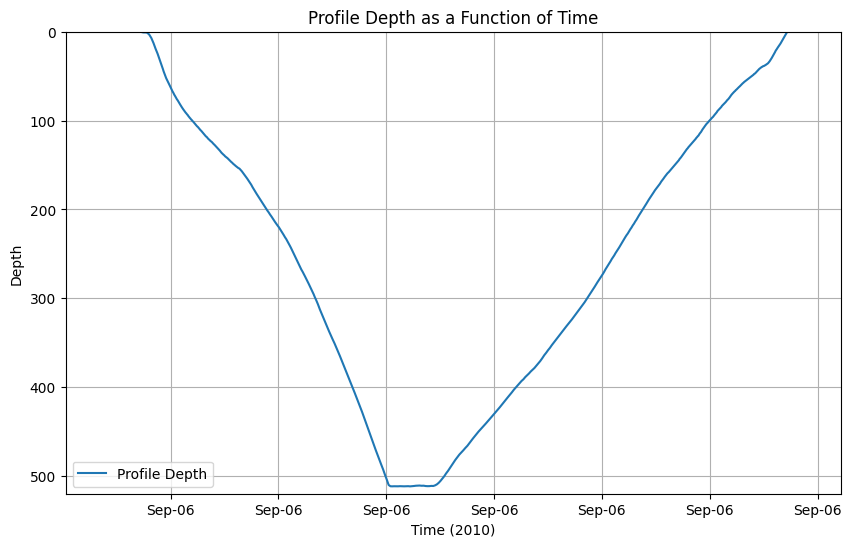

In [7]:
# Loads one dataset (p0150500_20050213.nc)
ds = readers.load_sample_dataset()

ds_OG1, var_list = convertOG1.convert_to_OG1(ds)

# Check the results - uncomment the following lines to either generate a plot or show the variables.
plotters.plot_profile_depth(ds_OG1)

In [8]:
### print the list of inital variables of the dataset
var_list

['log_DATA_FILE_SIZE',
 'log_T_BOOST',
 'sg_cal_optode_FoilCoefB4',
 'log_PHONE_SUPPLY',
 'log_SIM_W',
 'log_XPDR_DEVICE',
 'gc_vbd_ctl',
 'sg_cal_optode_FoilCoefA10',
 'log_VBD_BLEED_AD_RATE',
 'log_SPEED_LIMITS',
 'log_ROLL_MAXERRORS',
 'depth_avg_curr_error',
 'sg_cal_vbd_cnts_per_cc',
 'log_TGT_DEFAULT_LON',
 'surface_curr_east',
 'log_TT8_MAMPS',
 'avg_latitude',
 'sg_cal_hd_c',
 'log_SENSORS',
 'log_AH0_24V',
 'depth_avg_curr_east_gsm',
 'log_GPS2',
 'log_ALTIM_TOP_PING',
 'log_STROBE',
 'log_ESCAPE_HEADING_DELTA',
 'log__SM_DEPTHo',
 'ctd_depth',
 'log_DEVICE4',
 'log_NAV_MODE',
 'log_MASS',
 'sg_cal_optode_FoilCoefB11',
 'log_CF8_MAXERRORS',
 'GPS2_qc',
 'log_ALTIM_PING_DEPTH',
 'ctd_pressure',
 'speed_gsm',
 'eng_pitchAng',
 'log_KERMIT',
 'log_D_OFFGRID',
 'conductivity_raw',
 'log_P_OVSHOOT',
 'log_ROLL_ADJ_DBAND',
 'surface_curr_error',
 'log_ICE_FREEZE_MARGIN',
 'log_RELAUNCH',
 'depth_avg_curr_north',
 'gc_data_pts',
 'log_N_GPS',
 'log_SEABIRD_C_G',
 'sg_cal_sg_configura

In [9]:
# Print to screen a table of attributes
plotters.show_contents(ds_OG1,'attrs')

information is based on xarray Dataset


,Attribute,Value,DType
0,title,OceanGliders trajectory file,str
1,id,sg033_20100906T112156_delayed,str
2,platform,sub-surface gliders,str
3,platform_vocabulary,https://vocab.nerc.ac.uk/collection/L06/curren...,str
4,naming_authority,edu.washington.apl,str
5,institution,School of Oceanography\nUniversity of Washingt...,str
6,geospatial_lat_min,18.516025675252838,ndarray
7,geospatial_lat_max,18.524446699350996,ndarray
8,geospatial_lon_min,-65.98221600599415,ndarray
9,geospatial_lon_max,-65.97450004341222,ndarray


In [10]:
# Print to screen a table of the variables and variable attributes
plotters.show_contents(ds_OG1,'variables')

information is based on xarray Dataset


,dims,units,comment,standard_name,dtype
name,,,,,
CNDC,N_MEASUREMENTS,S/m,Conductivity corrected for anomalies,sea_water_electrical_conductivity,float32
CNDC_QC,N_MEASUREMENTS,,Whether to trust each corrected conductivity value,status_flag,float32
CNDC_RAW,N_MEASUREMENTS,S/m,Uncorrected conductivity,,float32
CNDC_RAW_QC,N_MEASUREMENTS,,Whether to trust each raw conductivity value,status_flag,float32
DAVG_CURR_EAST,N_MEASUREMENTS,m/s,Eastward component of the dive depth-average current based on hdm,eastward_sea_water_velocity,float32
DAVG_CURR_NORTH,N_MEASUREMENTS,m/s,Northward component of the dive depth-average current based on hdm,northward_sea_water_velocity,float32
DEPTH,N_MEASUREMENTS,m,from science pressure and interpolated,depth,float64
DEPTH_Z,N_MEASUREMENTS,meters,"Depth calculated from pressure using gsw library, positive up.",depth,float64
DOXY,N_MEASUREMENTS,micromoles/kg,"Dissolved oxygen concentration, calculated from optode tcphase corrected for salininty and depth",mole_concentration_of_dissolved_molecular_oxygen_in_sea_water,float32


### Convert mission from a local directory of basestation files

- For local data in the directory `input_dir`
- Creates a plot of ctd_depth against ctd_time.


Processing datasets:   0%|          | 0/5 [00:00<?, ?dataset/s]Variable 'vert_speed_gsm' not in OG1 vocabulary.
Variable 'speed_gsm' not in OG1 vocabulary.
Variable 'sound_velocity' not in OG1 vocabulary.
No conversion information found for micromoles/kg to micromoles/kg
Variable 'north_displacement_gsm' not in OG1 vocabulary.
Variable 'longitude_gsm' not in OG1 vocabulary.
Variable 'latitude_gsm' not in OG1 vocabulary.
Variable 'horz_speed_gsm' not in OG1 vocabulary.
Variable 'glide_angle_gsm' not in OG1 vocabulary.
No conversion information found for cm s-1 to cm s-1
Variable 'eng_wlbb2f_VFtemp' not in OG1 vocabulary.
Variable 'eng_tempFreq' not in OG1 vocabulary.
Variable 'eng_sbe43_O2Freq' not in OG1 vocabulary.
Variable 'eng_elaps_t_0000' not in OG1 vocabulary.
Variable 'eng_elaps_t' not in OG1 vocabulary.
Variable 'eng_depth' not in OG1 vocabulary.
Variable 'eng_condFreq' not in OG1 vocabulary.
Variable 'east_displacement_gsm' not in OG1 vocabulary.
No conversion information foun

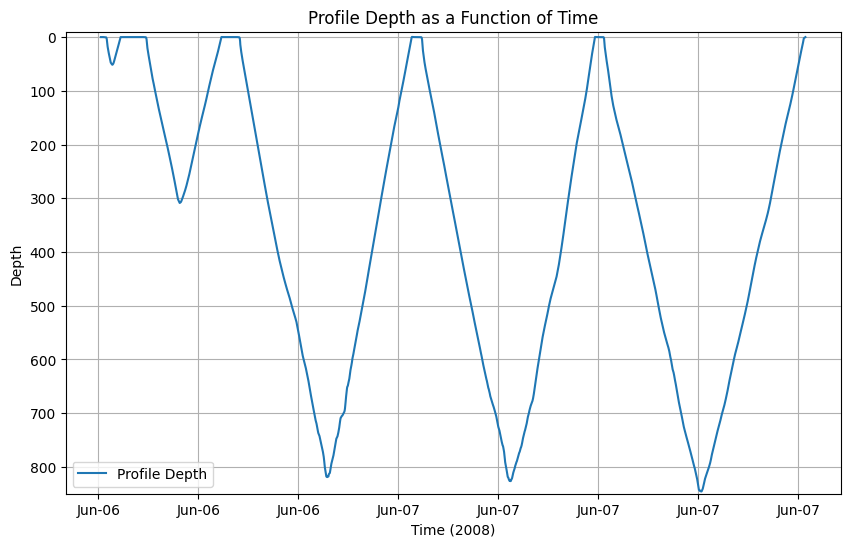

information is based on xarray Dataset


,Attribute,Value,DType
0,title,OceanGliders trajectory file,str
1,id,sg005_20080606T180738_delayed,str
2,platform,sub-surface gliders,str
3,platform_vocabulary,https://vocab.nerc.ac.uk/collection/L06/curren...,str
4,naming_authority,edu.washington.apl,str
5,institution,School of Oceanography\nUniversity of Washingt...,str
6,geospatial_lat_min,61.41231666666666,ndarray
7,geospatial_lat_max,61.57591666666667,ndarray
8,geospatial_lon_min,-8.747133333333332,ndarray
9,geospatial_lon_max,-8.273983333333332,ndarray


In [11]:
# Specify the input directory on your local machine
input_dir = data_path + '/demo_sg005' ### chose the input directory with your data

# Load and concatenate all datasets in the input directory
# Optionally, specify the range of profiles to load (start_profile, end_profile)
list_datasets = readers.load_basestation_files(input_dir, start_profile=1, end_profile=5)

# Convert the list of datasets to OG1
ds_OG1, var_list = convertOG1.convert_to_OG1(list_datasets)

# Generate a simple plot
plotters.plot_profile_depth(ds_OG1)
plotters.show_contents(ds_OG1,'attrs')

### Convert mission from the NCEI server (with p*nc files)

- Data from the sg015 mission in the Labrador Sea (https://www.ncei.noaa.gov/access/metadata/landing-page/bin/iso?id=gov.noaa.nodc:0111844), dataset identifier gov.noaa.nodc:0111844.


In [12]:
# Specify the server where data are located
server = "https://www.ncei.noaa.gov/data/oceans/glider/seaglider/uw/033/20100903/"

# Load and concatenate all datasets from the server, optionally specifying the range of profiles to load
list_datasets = readers.load_basestation_files(server, start_profile=1, end_profile=19)

# Convert the list of datasets to OG1
ds_OG1, var_list = convertOG1.convert_to_OG1(list_datasets)

Processing datasets:   0%|          | 0/19 [00:00<?, ?dataset/s]Variable 'eng_depth' not in OG1 vocabulary.
Variable 'eng_aa4330_Temp' not in OG1 vocabulary.
Variable 'longitude_gsm' not in OG1 vocabulary.
Variable 'speed_gsm' not in OG1 vocabulary.
Variable 'vert_speed_gsm' not in OG1 vocabulary.
Variable 'eng_aa4330_TCPhase' not in OG1 vocabulary.
Variable 'eng_sbect_tempFreq' not in OG1 vocabulary.
Variable 'eng_sbect_condFreq' not in OG1 vocabulary.
Variable 'eng_rec' not in OG1 vocabulary.
Variable 'north_displacement_gsm' not in OG1 vocabulary.
Variable 'horz_speed_gsm' not in OG1 vocabulary.
No conversion information found for micromoles/kg to micromoles/kg
Variable 'eng_aa4330_O2' not in OG1 vocabulary.
Variable 'eng_aa4330_AirSat' not in OG1 vocabulary.
Variable 'latitude_gsm' not in OG1 vocabulary.
Variable 'aanderaa4330_instrument_dissolved_oxygen' not in OG1 vocabulary.
Variable 'eng_elaps_t_0000' not in OG1 vocabulary.
Variable 'buoyancy' not in OG1 vocabulary.
Variable 'e

## Saving data

Due to problems with writing `xarray` datasets as netCDF when attributes are not of a specified type (`str`, `Number`, `np.ndarray`, `np.number`, `list`, `tuple`), a function was written `save_dataset`.

In [13]:
# Write the file
# This writer catches errors in data types (DType errors) when using xr.to_netcdf()
# The solution is to convert them to strings, which may be undesired behaviour
output_file = os.path.join(data_path, 'demo_test.nc')
if os.path.exists(output_file):
    os.remove(output_file)

writers.save_dataset(ds_OG1, output_file);

/Users/tillmoritz/Desktop/Work/Git/seagliderOG1/seagliderOG1/writers.py:38: UserWarning: Times can't be serialized faithfully to int64 with requested units 'seconds since 1970-01-01T00:00:00+00:00'. Resolution of 'nanoseconds' needed. Serializing times to floating point instead. Set encoding['dtype'] to integer dtype to serialize to int64. Set encoding['dtype'] to floating point dtype to silence this warning.
  ds.to_netcdf(output_file, format="NETCDF4")


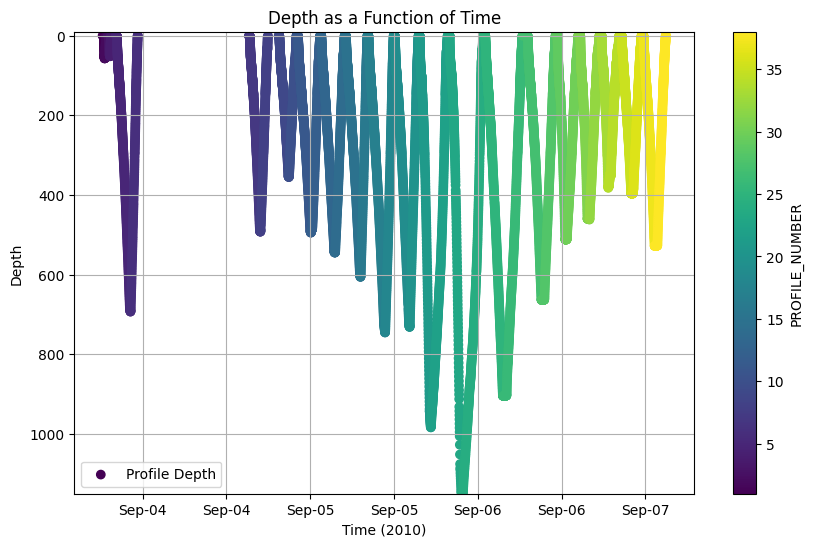

In [14]:
# Load the data saved
ds1 = xr.open_dataset(output_file)

# Generate a simple plot
#plotters.show_contents(ds_all,'attrs')
plotters.plot_depth_colored(ds1, color_by='PROFILE_NUMBER')


## Run multiple missions

In [15]:
# Add these to existing attributes - update to your details
contrib_to_append = vocabularies.contrib_to_append
print(contrib_to_append)

{'contributor_name': 'Eleanor Frajka-Williams', 'contributor_email': 'eleanorfrajka@gmail.com', 'contributor_role': 'Data scientist', 'contributor_role_vocabulary': 'http://vocab.nerc.ac.uk/search_nvs/W08', 'contributing_institutions': 'University of Hamburg - Institute of Oceanography', 'contributing_institutions_vocabulary': 'https://edmo.seadatanet.org/report/1156', 'contributing_institutions_role': 'Data scientist', 'contributing_institutions_role_vocabulary': 'http://vocab.nerc.ac.uk/search_nvs/W08'}


In [16]:
# Specify a list of servers or local directories
input_locations = [
    # Either Iceland, Faroes or RAPID/MOCHA
    #"https://www.ncei.noaa.gov/data/oceans/glider/seaglider/uw/005/20090829/", # done
    #"https://www.ncei.noaa.gov/data/oceans/glider/seaglider/uw/005/20080606/", # done
    #"https://www.ncei.noaa.gov/data/oceans/glider/seaglider/uw/005/20081106/", # done
    #"https://www.ncei.noaa.gov/data/oceans/glider/seaglider/uw/012/20070831/", # done
    #"https://www.ncei.noaa.gov/data/oceans/glider/seaglider/uw/014/20080214/",  # done
    #"https://www.ncei.noaa.gov/data/oceans/glider/seaglider/uw/014/20080222/", # done
    #"https://www.ncei.noaa.gov/data/oceans/glider/seaglider/uw/016/20061112/",  # done
    #"https://www.ncei.noaa.gov/data/oceans/glider/seaglider/uw/016/20090605/", # done
    #"https://www.ncei.noaa.gov/data/oceans/glider/seaglider/uw/016/20071113/", # done
    #"https://www.ncei.noaa.gov/data/oceans/glider/seaglider/uw/016/20080607/",  # done
    #"https://www.ncei.noaa.gov/data/oceans/glider/seaglider/uw/033/20100518/", # done
    "https://www.ncei.noaa.gov/data/oceans/glider/seaglider/uw/033/20100903/", # done
    #"https://www.ncei.noaa.gov/data/oceans/glider/seaglider/uw/101/20081108/",     # done
    #"https://www.ncei.noaa.gov/data/oceans/glider/seaglider/uw/101/20061112/",    # done
    #"https://www.ncei.noaa.gov/data/oceans/glider/seaglider/uw/101/20070609/",   # done
    #"https://www.ncei.noaa.gov/data/oceans/glider/seaglider/uw/102/20061112/",  # done
    # Labrador Sea
    #"https://www.ncei.noaa.gov/data/oceans/glider/seaglider/uw/015/20040924/",
    #"https://www.ncei.noaa.gov/data/oceans/glider/seaglider/uw/014/20040924/",
    #"https://www.ncei.noaa.gov/data/oceans/glider/seaglider/uw/008/20031002/",
    #"https://www.ncei.noaa.gov/data/oceans/glider/seaglider/uw/004/20031002/",
    #"https://www.ncei.noaa.gov/data/oceans/glider/seaglider/uw/016/20050406/",
    # RAPID/MOCHA
    #"https://www.ncei.noaa.gov/data/oceans/glider/seaglider/uw/033/20100729/",
    #"https://www.ncei.noaa.gov/data/oceans/glider/seaglider/uw/034/20110128/",
]

for input_loc in input_locations:
    # Example usage
    ds_all = convertOG1.process_and_save_data(input_loc, output_dir=data_path, save=True,  run_quietly=True)

Processing datasets:   0%|          | 0/1 [00:00<?, ?dataset/s]Variable 'eng_depth' not in OG1 vocabulary.
Variable 'eng_aa4330_Temp' not in OG1 vocabulary.
Variable 'longitude_gsm' not in OG1 vocabulary.
Variable 'speed_gsm' not in OG1 vocabulary.
Variable 'vert_speed_gsm' not in OG1 vocabulary.
Variable 'eng_aa4330_TCPhase' not in OG1 vocabulary.
Variable 'eng_sbect_tempFreq' not in OG1 vocabulary.
Variable 'eng_sbect_condFreq' not in OG1 vocabulary.
Variable 'eng_rec' not in OG1 vocabulary.
Variable 'north_displacement_gsm' not in OG1 vocabulary.
Variable 'horz_speed_gsm' not in OG1 vocabulary.
No conversion information found for micromoles/kg to micromoles/kg
Variable 'eng_aa4330_O2' not in OG1 vocabulary.
Variable 'eng_aa4330_AirSat' not in OG1 vocabulary.
Variable 'latitude_gsm' not in OG1 vocabulary.
Variable 'aanderaa4330_instrument_dissolved_oxygen' not in OG1 vocabulary.
Variable 'eng_elaps_t_0000' not in OG1 vocabulary.
Variable 'buoyancy' not in OG1 vocabulary.
Variable 'ea

File /Users/tillmoritz/Desktop/Work/Git/seagliderOG1/data/sg033_20100903T182416_delayed.nc already exists. Exiting the process.
